## Generate the mesh

In [1]:
from mesh import three_cubes

size = 0.05
filename = f"meshes/mesh_{size}.msh"

three_cubes(filename, size=size)

Info    : Meshing 1D...nts                                                                                                             
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 20%] Meshing curve 4 (Line)
Info    : [ 20%] Meshing curve 5 (Line)
Info    : [ 20%] Meshing curve 6 (Line)
Info    : [ 30%] Meshing curve 7 (Line)
Info    : [ 30%] Meshing curve 8 (Line)
Info    : [ 30%] Meshing curve 9 (Line)
Info    : [ 40%] Meshing curve 10 (Line)
Info    : [ 40%] Meshing curve 11 (Line)
Info    : [ 40%] Meshing curve 12 (Line)
Info    : [ 50%] Meshing curve 13 (Line)
Info    : [ 50%] Meshing curve 14 (Line)
Info    : [ 60%] Meshing curve 15 (Line)
Info    : [ 60%] Meshing curve 16 (Line)
Info    : [ 60%] Meshing curve 17 (Line)
Info    : [ 70%] Meshing curve 18 (Line)
Info    : [ 70%] Meshing curve 19 (Line)
Info    : [ 70%] Meshing curve 20 (Line)
Info    : [ 80%] Meshing curve 21 (Line)
Info    : [ 

In [2]:
from convert_mesh import convert_mesh

volume_file = f"meshes/mesh_{size}.xdmf"
facet_file = f"meshes/mesh_{size}_facet.xdmf"

print(filename, volume_file, facet_file)
nb_cells, nb_facets = convert_mesh(filename, volume_file, facet_file)


meshes/mesh_0.05.msh meshes/mesh_0.05.xdmf meshes/mesh_0.05_facet.xdmf

Surface IDs:  [4 5 6 7]
Volume IDs:  [1 2 3]


In [3]:
import ipyparallel as ipp
import numpy as np

def run(volume_file: str, facet_file: str) -> float:
    from script_festim_2 import run_festim_2
    import time

    start = time.perf_counter()
    run_festim_2(volume_file, facet_file)
    end = time.perf_counter()

    elapsed_time = end - start


    return elapsed_time

# check if we are in github actions
import os
if "CI" in os.environ:
    num_procs = [1, 2, 4]
else:
    num_procs = [1, 2, 4, 8, 16]

runtimes = np.zeros_like(num_procs, dtype=np.float64)

for i, num_proc in enumerate(num_procs):
    print(f"Running with {num_proc} processes")


    # start an ipyparallel cluster and connect to it
    cluster = ipp.Cluster(engines="mpi", n=num_proc)
    rc = cluster.start_and_connect_sync()

    # run the function run in parallel
    query = rc[:].apply_async(run, volume_file, facet_file)
    query.wait()

    # get the results for all processes
    elapsed_times = query.get()
    rc.cluster.stop_cluster_sync()
    cluster.stop_cluster()

    print(elapsed_times)
    rc.cluster.stop_cluster_sync()
    cluster.stop_cluster()

    runtime = np.max(elapsed_times)
    print(f"Elapsed times: {elapsed_times} seconds, max {runtime=:.2e}")

    runtimes[i] = runtime

Running with 1 processes
Starting 1 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 1/1 [00:05<00:00,  5.49s/engine]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 1651161, 'identifier': 'ipcontroller-1731460182-nmp8-1651142'}
Stopping engine(s): 1731460183
Output for ipengine-1731460182-nmp8-1731460183-1651142:
2024-11-12 20:09:44.053 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-12 20:09:44.053 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-12 20:09:44.142 [IPEngine] Registering with controller at tcp://127.0.0.1:38811
2024-11-12 20:09:44.144 [IPEngine] Shell_addrs: ['tcp://127.0.0.1:56631', 'tcp://127.0.0.1:33881', 'tcp://127.0.0.1:39431']
2024-11-12 20:09:44.144 [IPEngine] Connecting shell to tcp://127.0.0.1:56631
2024-11-12 20:09:44.144 [IPEngine] Connecting shell to tcp://127.0.0.1:33881
2024-11-12 20:09:44.144 [IPEngine] Connecting shell to tcp://127.0.0.1:39431
2024-11-12 20:09:44.144 [I

/tmp/ipykernel_1651142/4245574397.py:41: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()
/tmp/ipykernel_1651142/4245574397.py:45: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


Starting 2 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 2/2 [00:05<00:00,  2.76s/engine]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 1651275, 'identifier': 'ipcontroller-1731460220-wum8-1651142'}
Stopping engine(s): 1731460221
Output for ipengine-1731460220-wum8-1731460221-1651142:
2024-11-12 20:10:21.411 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-12 20:10:21.411 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-12 20:10:21.411 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-12 20:10:21.411 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-12 20:10:21.459 [IPEngine.1] Registering with controller at tcp://127.0.0.1:34675
2024-11-12 20:10:21.459 [IPEngine.0] Registering with controller at tcp://127.0.0.1:34675
2024-11-12 20:10:21.459 [IPEngine.0] Requesting id: 0
2024-11-12 20:10:21.459 [IPEngine.1] Requesting id: 1
2024-11-12 20:10:21.460 [IPEngine.1] Shell_addrs

/tmp/ipykernel_1651142/4245574397.py:41: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()
/tmp/ipykernel_1651142/4245574397.py:45: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


Starting 4 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 4/4 [00:05<00:00,  1.37s/engine]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 1651395, 'identifier': 'ipcontroller-1731460250-mtf8-1651142'}
Stopping engine(s): 1731460251
Output for ipengine-1731460250-mtf8-1731460251-1651142:
2024-11-12 20:10:51.354 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-12 20:10:51.354 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-12 20:10:51.356 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-12 20:10:51.356 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-12 20:10:51.356 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-12 20:10:51.356 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-12 20:10:51.357 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-12 20:10:51.357 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-12 20:10:51.

/tmp/ipykernel_1651142/4245574397.py:41: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()
/tmp/ipykernel_1651142/4245574397.py:45: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


Starting 8 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 8/8 [00:05<00:00,  1.44engine/s]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 1651535, 'identifier': 'ipcontroller-1731460277-92as-1651142'}
Stopping engine(s): 1731460278
Output for ipengine-1731460277-92as-1731460278-1651142:
2024-11-12 20:11:18.644 [IPEngine.5] Starting nanny
2024-11-12 20:11:18.644 [IPEngine.7] Connecting shell to tcp://127.0.0.1:54947
2024-11-12 20:11:18.644 [IPEngine.7] Connecting shell to tcp://127.0.0.1:36391
2024-11-12 20:11:18.644 [IPEngine.7] Starting nanny
2024-11-12 20:11:18.941 [KernelNanny.0] Starting kernel nanny for engine 0, pid=1651568, nanny pid=1651605
2024-11-12 20:11:18.941 [KernelNanny.0] Nanny watching parent pid 1651568.
2024-11-12 20:11:18.953 [KernelNanny.5] Starting kernel nanny for engine 5, pid=1651573, nanny pid=1651606
2024-11-12 20:11:18.954 [KernelNanny.5] Nanny watching parent pid 1651573.
2024-11-12 20:11:18.956 [K

/tmp/ipykernel_1651142/4245574397.py:41: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()
/tmp/ipykernel_1651142/4245574397.py:45: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


Starting 16 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 16/16 [00:05<00:00,  2.88engine/s]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 1651763, 'identifier': 'ipcontroller-1731460304-fns5-1651142'}
Stopping engine(s): 1731460305
Output for ipengine-1731460304-fns5-1731460305-1651142:
2024-11-12 20:11:46.268 [IPEngine.9] Starting to monitor the heartbeat signal from the hub every 3500 ms.
2024-11-12 20:11:46.269 [IPEngine.9] Completed registration with id 9
2024-11-12 20:11:46.269 [IPEngine.13] Starting to monitor the heartbeat signal from the hub every 3500 ms.
2024-11-12 20:11:46.269 [IPEngine.13] Completed registration with id 13
2024-11-12 20:11:46.275 [IPEngine.8] Running code in user namespace: 
from mpi4py import MPI
mpi_rank = MPI.COMM_WORLD.Get_rank()
mpi_size = MPI.COMM_WORLD.Get_size()

2024-11-12 20:11:46.276 [IPEngine.5] Running code in user namespace: 
from mpi4py import MPI
mpi_rank = MPI.COMM_WORLD.Get_ran

/tmp/ipykernel_1651142/4245574397.py:41: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()
/tmp/ipykernel_1651142/4245574397.py:45: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


In [4]:
def run_penalty(volume_file: str, facet_file: str) -> float:
    from script_festim_2 import run_festim_2_penalty
    import time

    start = time.perf_counter()
    run_festim_2_penalty(volume_file, facet_file)
    end = time.perf_counter()

    elapsed_time = end - start


    return elapsed_time


import ipyparallel as ipp
import numpy as np

# check if we are in github actions
import os
if "CI" in os.environ:
    num_procs = [1, 2, 4]
else:
    num_procs = [1, 2, 4, 8, 16]

runtimes_penalty = np.zeros_like(num_procs, dtype=np.float64)

for i, num_proc in enumerate(num_procs):
    print(f"Running with {num_proc} processes")


    # start an ipyparallel cluster and connect to it
    cluster = ipp.Cluster(engines="mpi", n=num_proc)
    rc = cluster.start_and_connect_sync()

    # run the function run in parallel
    query = rc[:].apply_async(run_penalty, volume_file, facet_file)
    query.wait()

    # get the results for all processes
    elapsed_times = query.get()
    rc.cluster.stop_cluster_sync()
    cluster.stop_cluster()

    print(elapsed_times)
    rc.cluster.stop_cluster_sync()
    cluster.stop_cluster()

    runtime = np.max(elapsed_times)
    print(f"Elapsed times: {elapsed_times} seconds, max {runtime=:.2e}")

    runtimes_penalty[i] = runtime


Running with 1 processes
Starting 1 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 1/1 [00:05<00:00,  5.54s/engine]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 1652216, 'identifier': 'ipcontroller-1731460405-751z-1651142'}
Stopping engine(s): 1731460406
Output for ipengine-1731460405-751z-1731460406-1651142:
2024-11-12 20:13:27.193 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-12 20:13:27.193 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-12 20:13:27.244 [IPEngine] Registering with controller at tcp://127.0.0.1:41093
2024-11-12 20:13:27.245 [IPEngine] Shell_addrs: ['tcp://127.0.0.1:47607', 'tcp://127.0.0.1:37933', 'tcp://127.0.0.1:35031']
2024-11-12 20:13:27.245 [IPEngine] Connecting shell to tcp://127.0.0.1:47607
2024-11-12 20:13:27.245 [IPEngine] Connecting shell to tcp://127.0.0.1:37933
2024-11-12 20:13:27.246 [IPEngine] Connecting shell to tcp://127.0.0.1:35031
2024-11-12 20:13:27.246 [I

/tmp/ipykernel_1651142/801050669.py:42: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()
/tmp/ipykernel_1651142/801050669.py:46: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


Starting 2 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 2/2 [00:05<00:00,  2.77s/engine]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 1652329, 'identifier': 'ipcontroller-1731460446-921c-1651142'}
Stopping engine(s): 1731460447
Output for ipengine-1731460446-921c-1731460447-1651142:
2024-11-12 20:14:07.690 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-12 20:14:07.690 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-12 20:14:07.690 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-12 20:14:07.690 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-12 20:14:07.775 [IPEngine.1] Registering with controller at tcp://127.0.0.1:56093
2024-11-12 20:14:07.775 [IPEngine.0] Registering with controller at tcp://127.0.0.1:56093
2024-11-12 20:14:07.775 [IPEngine.1] Requesting id: 1
2024-11-12 20:14:07.775 [IPEngine.0] Requesting id: 0
2024-11-12 20:14:07.777 [IPEngine.0] Shell_addrs

/tmp/ipykernel_1651142/801050669.py:42: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()
/tmp/ipykernel_1651142/801050669.py:46: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


Starting 4 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 4/4 [00:05<00:00,  1.39s/engine]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 1652461, 'identifier': 'ipcontroller-1731460477-yobg-1651142'}
Stopping engine(s): 1731460478
Output for ipengine-1731460477-yobg-1731460478-1651142:
2024-11-12 20:14:39.019 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-12 20:14:39.019 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-12 20:14:39.022 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-12 20:14:39.022 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-12 20:14:39.024 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-12 20:14:39.024 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-12 20:14:39.024 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-12 20:14:39.024 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-12 20:14:39.

/tmp/ipykernel_1651142/801050669.py:42: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()
/tmp/ipykernel_1651142/801050669.py:46: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


Starting 8 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 8/8 [00:05<00:00,  1.44engine/s]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 1652599, 'identifier': 'ipcontroller-1731460505-dklz-1651142'}
Stopping engine(s): 1731460506
Output for ipengine-1731460505-dklz-1731460506-1651142:
2024-11-12 20:15:06.705 [IPEngine.2] Connecting shell to tcp://127.0.0.1:47307
2024-11-12 20:15:06.705 [IPEngine.2] Connecting shell to tcp://127.0.0.1:58957
2024-11-12 20:15:06.705 [IPEngine.2] Connecting shell to tcp://127.0.0.1:48979
2024-11-12 20:15:06.705 [IPEngine.2] Starting nanny
2024-11-12 20:15:06.705 [IPEngine.4] Shell_addrs: ['tcp://127.0.0.1:47307', 'tcp://127.0.0.1:58957', 'tcp://127.0.0.1:48979']
2024-11-12 20:15:06.705 [IPEngine.4] Connecting shell to tcp://127.0.0.1:47307
2024-11-12 20:15:06.705 [IPEngine.4] Connecting shell to tcp://127.0.0.1:58957
2024-11-12 20:15:06.706 [IPEngine.4] Connecting shell to tcp://127.0.0.1:48979


/tmp/ipykernel_1651142/801050669.py:42: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()
/tmp/ipykernel_1651142/801050669.py:46: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


Starting 16 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 16/16 [00:05<00:00,  2.87engine/s]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 1652813, 'identifier': 'ipcontroller-1731460532-gdtt-1651142'}
Stopping engine(s): 1731460533
Output for ipengine-1731460532-gdtt-1731460533-1651142:

2024-11-12 20:15:34.699 [IPEngine.9] Running code in user namespace: 
from mpi4py import MPI
mpi_rank = MPI.COMM_WORLD.Get_rank()
mpi_size = MPI.COMM_WORLD.Get_size()

2024-11-12 20:15:34.699 [IPEngine.10] Running code in user namespace: 
from mpi4py import MPI
mpi_rank = MPI.COMM_WORLD.Get_rank()
mpi_size = MPI.COMM_WORLD.Get_size()

2024-11-12 20:15:34.700 [IPEngine.4] Running code in user namespace: 
from mpi4py import MPI
mpi_rank = MPI.COMM_WORLD.Get_rank()
mpi_size = MPI.COMM_WORLD.Get_size()

2024-11-12 20:15:34.700 [IPEngine.5] WARNING | debugpy_stream undefined, debugging will not be enabled
2024-11-12 20:15:34.701 [IPEngine.1] Run

/tmp/ipykernel_1651142/801050669.py:42: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()
/tmp/ipykernel_1651142/801050669.py:46: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


In [5]:
def run_change_of_var(volume_file: str, facet_file: str) -> float:
    from script_festim_2 import run_festim_2_change_of_var
    import time

    start = time.perf_counter()
    run_festim_2_change_of_var(volume_file, facet_file)
    end = time.perf_counter()

    elapsed_time = end - start


    return elapsed_time


import ipyparallel as ipp
import numpy as np

# check if we are in github actions
import os
if "CI" in os.environ:
    num_procs = [1, 2, 4]
else:
    num_procs = [1, 2, 4, 8, 16]

runtimes_change_of_var = np.zeros_like(num_procs, dtype=np.float64)

for i, num_proc in enumerate(num_procs):
    print(f"Running with {num_proc} processes")


    # start an ipyparallel cluster and connect to it
    cluster = ipp.Cluster(engines="mpi", n=num_proc)
    rc = cluster.start_and_connect_sync()

    # run the function run in parallel
    query = rc[:].apply_async(run_change_of_var, volume_file, facet_file)
    query.wait()

    # get the results for all processes
    elapsed_times = query.get()
    rc.cluster.stop_cluster_sync()
    cluster.stop_cluster()

    print(elapsed_times)
    rc.cluster.stop_cluster_sync()
    cluster.stop_cluster()

    runtime = np.max(elapsed_times)
    print(f"Elapsed times: {elapsed_times} seconds, max {runtime=:.2e}")

    runtimes_change_of_var[i] = runtime


Running with 1 processes
Starting 1 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 1/1 [00:05<00:00,  5.60s/engine]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 1653185, 'identifier': 'ipcontroller-1731460580-4cxq-1651142'}
Stopping engine(s): 1731460582
Output for ipengine-1731460580-4cxq-1731460582-1651142:
2024-11-12 20:16:22.282 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-12 20:16:22.283 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-12 20:16:22.351 [IPEngine] Registering with controller at tcp://127.0.0.1:33095
2024-11-12 20:16:22.353 [IPEngine] Shell_addrs: ['tcp://127.0.0.1:36737', 'tcp://127.0.0.1:46099', 'tcp://127.0.0.1:44295']
2024-11-12 20:16:22.354 [IPEngine] Connecting shell to tcp://127.0.0.1:36737
2024-11-12 20:16:22.354 [IPEngine] Connecting shell to tcp://127.0.0.1:46099
2024-11-12 20:16:22.354 [IPEngine] Connecting shell to tcp://127.0.0.1:44295
2024-11-12 20:16:22.354 [I

/tmp/ipykernel_1651142/2137199539.py:42: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()
/tmp/ipykernel_1651142/2137199539.py:46: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


Starting 2 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 2/2 [00:05<00:00,  2.76s/engine]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 1653298, 'identifier': 'ipcontroller-1731460617-6tg6-1651142'}
Stopping engine(s): 1731460618
Output for ipengine-1731460617-6tg6-1731460618-1651142:
2024-11-12 20:16:59.095 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-12 20:16:59.095 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-12 20:16:59.096 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-12 20:16:59.096 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-12 20:16:59.145 [IPEngine.0] Registering with controller at tcp://127.0.0.1:45207
2024-11-12 20:16:59.145 [IPEngine.1] Registering with controller at tcp://127.0.0.1:45207
2024-11-12 20:16:59.146 [IPEngine.0] Requesting id: 0
2024-11-12 20:16:59.146 [IPEngine.1] Requesting id: 1
2024-11-12 20:16:59.147 [IPEngine.1] Shell_addrs

/tmp/ipykernel_1651142/2137199539.py:42: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()
/tmp/ipykernel_1651142/2137199539.py:46: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


Starting 4 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 4/4 [00:05<00:00,  1.38s/engine]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 1653439, 'identifier': 'ipcontroller-1731460653-evp4-1651142'}
Stopping engine(s): 1731460654
Output for ipengine-1731460653-evp4-1731460654-1651142:
2024-11-12 20:17:34.470 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-12 20:17:34.470 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-12 20:17:34.471 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-12 20:17:34.471 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-12 20:17:34.471 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-12 20:17:34.471 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-12 20:17:34.472 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-12 20:17:34.472 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-12 20:17:34.

/tmp/ipykernel_1651142/2137199539.py:42: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()
/tmp/ipykernel_1651142/2137199539.py:46: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


Starting 8 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 8/8 [00:05<00:00,  1.43engine/s]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 1653577, 'identifier': 'ipcontroller-1731460680-iknt-1651142'}
Stopping engine(s): 1731460681
Output for ipengine-1731460680-iknt-1731460681-1651142:
2024-11-12 20:18:02.311 [IPEngine.1] Connecting shell to tcp://127.0.0.1:55447
2024-11-12 20:18:02.311 [IPEngine.1] Starting nanny
2024-11-12 20:18:02.311 [IPEngine.7] Shell_addrs: ['tcp://127.0.0.1:36259', 'tcp://127.0.0.1:38187', 'tcp://127.0.0.1:55447']
2024-11-12 20:18:02.312 [IPEngine.7] Connecting shell to tcp://127.0.0.1:36259
2024-11-12 20:18:02.312 [IPEngine.6] Shell_addrs: ['tcp://127.0.0.1:36259', 'tcp://127.0.0.1:38187', 'tcp://127.0.0.1:47601']
2024-11-12 20:18:02.312 [IPEngine.7] Connecting shell to tcp://127.0.0.1:38187
2024-11-12 20:18:02.312 [IPEngine.7] Connecting shell to tcp://127.0.0.1:55447
2024-11-12 20:18:02.312 [IPEngin

/tmp/ipykernel_1651142/2137199539.py:42: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()
/tmp/ipykernel_1651142/2137199539.py:46: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


Starting 16 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 16/16 [00:05<00:00,  2.88engine/s]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 1653791, 'identifier': 'ipcontroller-1731460709-yuyr-1651142'}
Stopping engine(s): 1731460710
Output for ipengine-1731460709-yuyr-1731460710-1651142:
from mpi4py import MPI
mpi_rank = MPI.COMM_WORLD.Get_rank()
mpi_size = MPI.COMM_WORLD.Get_size()

2024-11-12 20:18:31.468 [IPEngine.8] Starting to monitor the heartbeat signal from the hub every 3500 ms.
2024-11-12 20:18:31.468 [IPEngine.8] Completed registration with id 8
2024-11-12 20:18:31.469 [IPEngine.11] WARNING | debugpy_stream undefined, debugging will not be enabled
2024-11-12 20:18:31.471 [IPEngine.7] WARNING | debugpy_stream undefined, debugging will not be enabled
2024-11-12 20:18:31.472 [IPEngine.11] Starting to monitor the heartbeat signal from the hub every 3500 ms.
2024-11-12 20:18:31.472 [IPEngine.11] Completed registration 

/tmp/ipykernel_1651142/2137199539.py:42: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()
/tmp/ipykernel_1651142/2137199539.py:46: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


[lap-mathurin-01:1651142] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.lap-mathurin-01.1000/jf.0/113377280/shared_mem_cuda_pool.lap-mathurin-01 could be created.
[lap-mathurin-01:1651142] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


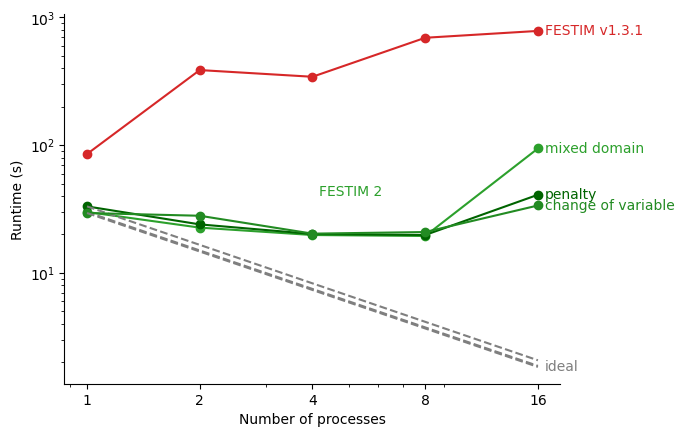

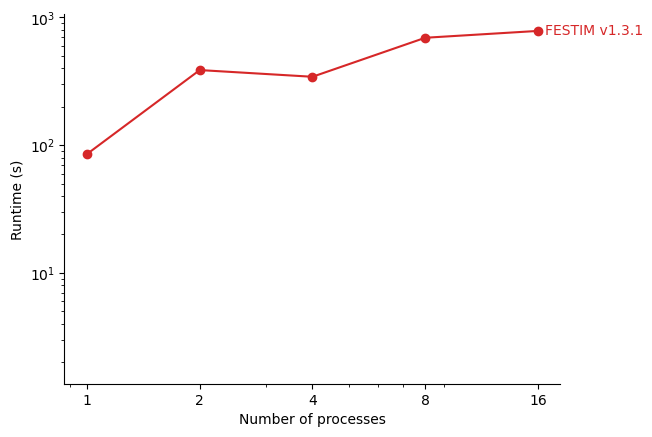

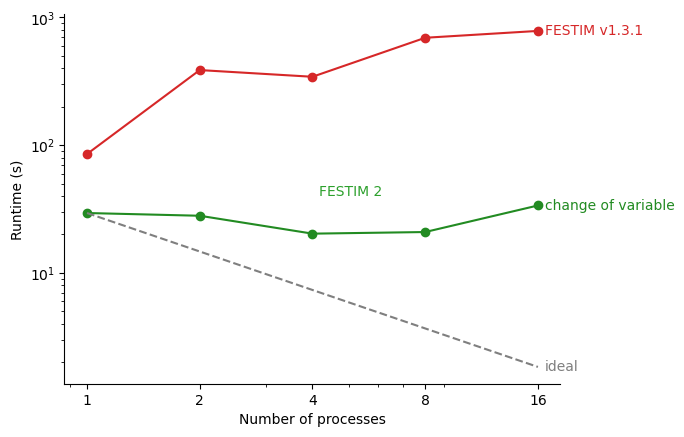

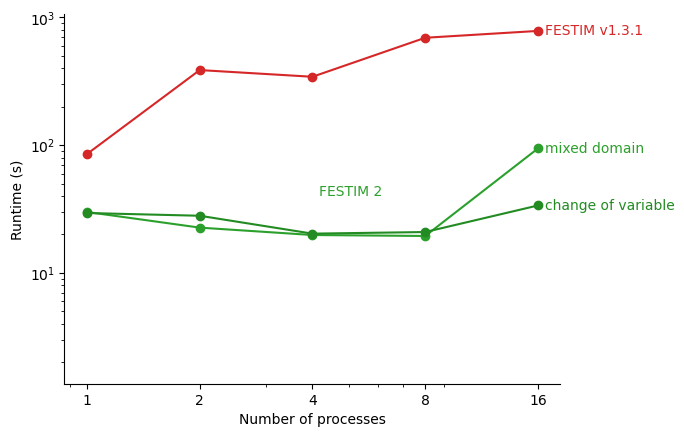

In [6]:
import matplotlib.pyplot as plt
from festim import __version__


def plot_runtime(
    runtimes_mixed: np.ndarray = None,
    runtimes_change_of_var: np.ndarray = None,
    penalty: np.ndarray = None,
    show_festim_1: bool = True,
    show_ideal: bool = True,
):
    lines = []
    if runtimes_mixed is not None:
        (l_mixed,) = plt.plot(
            num_procs, runtimes_mixed, marker="o", label=f"mixed domain", color="tab:green"
        )
        lines.append(l_mixed)
        if show_ideal:
            n = np.linspace(1, 16, 100)
            (l_ideal,) = plt.plot(
                n, runtimes_mixed[0] * n**-1, linestyle="--", color="tab:grey"
            )
            # lines.append(l_ideal)
    if penalty is not None:
        # another green
        (l_penalty,) = plt.plot(
            num_procs, runtimes_penalty, marker="o", label="penalty", color="darkgreen"
        )
        lines.append(l_penalty)
        if show_ideal:
            n = np.linspace(1, 16, 100)
            (l_ideal,) = plt.plot(
                n, runtimes_penalty[0] * n**-1, linestyle="--", color="tab:grey"
            )
            # lines.append(l_ideal)
    if runtimes_change_of_var is not None:
        (l_change_var,) = plt.plot(
            num_procs,
            runtimes_change_of_var,
            marker="o",
            label="change of variable",
            color="forestgreen",
        )
        lines.append(l_change_var)
        if show_ideal:
            n = np.linspace(1, 16, 100)
            (l_ideal,) = plt.plot(
                n,
                runtimes_change_of_var[0] * n**-1,
                label="ideal",
                linestyle="--",
                color="tab:grey",
            )
            lines.append(l_ideal)

    if show_festim_1:
        # check that runtimes_festim_1.csv exists and plot the results
        try:
            import pandas as pd

            data = pd.read_csv("runtimes_festim_1.csv")
            (l_festim1,) = plt.plot(
                data["num_procs"],
                data["runtimes"],
                marker="o",
                label="FESTIM v1.3.1",
                color="tab:red",
            )
            lines.append(l_festim1)
        except FileNotFoundError:
            print("File runtimes_festim_1.csv not found")

    for line in lines:
        plt.annotate(
            f"{line.get_label()}",
            (num_procs[-1], line.get_ydata()[-1]),
            textcoords="offset points",
            xytext=(5, 0),
            ha="left",
            va="center",
            color=line.get_color(),
        )

    if runtimes_mixed  is not None or runtimes_change_of_var is not None or penalty is not None:
        plt.annotate(
            "FESTIM 2",
            (num_procs[2], runtimes_change_of_var[2]),
            textcoords="offset points",
            xytext=(5, 30),
            ha="left",
            va="center",
            color="tab:green",
        )

    # plt.legend()
    plt.xlabel("Number of processes")
    plt.ylabel("Runtime (s)")

    plt.xscale("log")
    plt.yscale("log")

    # xticks only at the powers of 2
    plt.xticks(num_procs, num_procs)

    # remove top and right spines
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)

# show everything
plot_runtime(runtimes_change_of_var=runtimes_change_of_var, runtimes_mixed=runtimes, penalty=True, show_ideal=True)
ylim = plt.gca().get_ylim()
xlim = plt.gca().get_xlim()
plt.show()

# only festim1
plot_runtime()
plt.gca().set_ylim(ylim)
plt.gca().set_xlim(xlim)
plt.show()

# festim1 + change of var
plot_runtime(runtimes_change_of_var=runtimes_change_of_var)
plt.gca().set_ylim(ylim)
plt.gca().set_xlim(xlim)
plt.show()

# festim1 + change of var + mixed
plot_runtime(runtimes_change_of_var=runtimes_change_of_var, runtimes_mixed=runtimes, show_ideal=False)
plt.gca().set_ylim(ylim)
plt.gca().set_xlim(xlim)
plt.show()


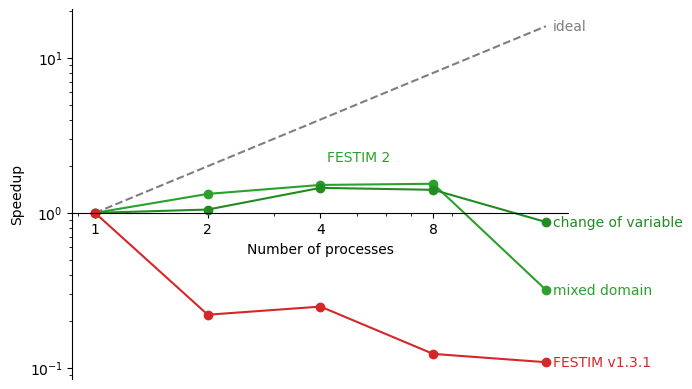

In [7]:
def plot_speedup(
    runtimes_mixed: np.ndarray = None,
    runtimes_change_of_var: np.ndarray = None,
    show_festim_1: bool = True,
    show_ideal: bool = True,
):
    lines = []
    if runtimes_mixed is not None:
        (l_mixed,) = plt.plot(
            num_procs, runtimes_mixed[0] / runtimes_mixed, marker="o", label=f"mixed domain", color="tab:green"
        )
        lines.append(l_mixed)

    if runtimes_change_of_var is not None:
        (l_change_var,) = plt.plot(
            num_procs,
            runtimes_change_of_var[0] / runtimes_change_of_var,
            marker="o",
            label="change of variable",
            color="forestgreen",
        )
        lines.append(l_change_var)

    if show_ideal:
        n = np.linspace(1, 16, 100)
        (l_ideal,) = plt.plot(
            n,
            n,
            label="ideal",
            linestyle="--",
            color="tab:grey",
        )
        lines.append(l_ideal)

    if show_festim_1:
        # check that runtimes_festim_1.csv exists and plot the results
        try:
            import pandas as pd

            data = pd.read_csv("runtimes_festim_1.csv")
            (l_festim1,) = plt.plot(
                data["num_procs"],
                data["runtimes"][0] / data["runtimes"],
                marker="o",
                label="FESTIM v1.3.1",
                color="tab:red",
            )
            lines.append(l_festim1)
        except FileNotFoundError:
            print("File runtimes_festim_1.csv not found")

    for line in lines:
        plt.annotate(
            f"{line.get_label()}",
            (num_procs[-1], line.get_ydata()[-1]),
            textcoords="offset points",
            xytext=(5, 0),
            ha="left",
            va="center",
            color=line.get_color(),
        )

    if runtimes_mixed is not None or runtimes_change_of_var is not None:
        plt.annotate(
            "FESTIM 2",
            (num_procs[2], runtimes[2]/runtimes[0]),
            textcoords="offset points",
            xytext=(5, 60),
            ha="left",
            va="center",
            color="tab:green",
        )

    # move xaxis to y=1
    plt.gca().spines['bottom'].set_position(('data', 1))

    # plt.legend()
    plt.xlabel("Number of processes")
    plt.ylabel("Speedup")

    plt.xscale("log")
    plt.yscale("log")

    # xticks only at the powers of 2
    plt.xticks(num_procs[:-1], num_procs[:-1])

    # remove top and right spines
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)

plot_speedup(runtimes_mixed=runtimes, runtimes_change_of_var=runtimes_change_of_var, show_ideal=True)